# Police Action Over Time

Let's start by importing our data - this is included here so you can reproduce this, but you don't *really* need to go over all this.

In [257]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
from scipy.stats import ttest_1samp as ttest1Samp
plt.rcParams['figure.figsize'] = [15, 5]

In [258]:
df = pd.read_excel('./../Formatted-Data/safety_security_and_fire_reports.xlsx')
dfSplit = np.split(df, df[df.isnull().all(1)].index) #split by blank lines

In [259]:
def getByLoc(dfList, location):
    for i,dfi in enumerate(dfList):
        if i>0:
            dfi.columns = dfi.iloc[1]
            dfi=dfi[2:]
        dfi.dropna(how='all') # Drop columns with no data reported (:eyes: @ 2018)
        dfi = dfi.drop(columns="Notes") # Remove Notes
        if "Location" in dfi.columns:
            dfi = dfi[dfi['Location']==location]
            deleteRows = 2 # For rows after blank lines, need to delete an extra row
        else:
            deleteRows = 1
        dfi = dfi.T # Transpose Data
        dfi = dfi.dropna(how='all') # Drop rows with no data reported
        dfi.columns = dfi.iloc[0]
        dfi=dfi[deleteRows:]
        if "Burglary" in dfi.columns:
            dfi = dfi.drop(columns="Burglary") # See below!
        dfList[i] = dfi
    return dfList

**Note:** I'm excluding burglary here as it's a large component of the overall crime, but wasn't collected/reported every year.

In [260]:
cats = ["Training", "Crime", "Arrest", "Discipline"]
locs = ["Campus", "Student Residences"]

ssfrData = {} 
for loc in locs:
    data = getByLoc(deepcopy(dfSplit), loc)
    for i, cat in enumerate(cats):       
        if not cat in ssfrData:
            ssfrData[cat] = {}
        ssfrData[cat][loc] = data[i]

For this analysis, I'm using arrests on *campus* which is defined by Stanford's report as:

**Campus:** "Any building or property owned or controlled by an institution within the same reasonably contiguous geographic area and used by the institution in direct support of, or in a manner related to, the institution’s educational purposes, including residence halls and Any building or property that is within or reasonably contiguous to paragraph (1) of this definition, that is owned by the institution but controlled by another person, is frequently used by students, and supports institutional purposes."

Why? While it's true that most student drinking happens in Student Residences, all arrests (save for 2014) made by the police aren't in Student Residences - it's really serving as a proxy for police enforcement anyways, so it should do just fine.

Just so we're clear, here are the other important definitions of the data types:

**Liquor Laws:** The violation of laws prohibiting the manufacture, sale, purchase, transportation, possession, or use of alcoholic beverages. Driving under the influence and drunkenness violations are excluded.

**Drug Laws:** Violations of laws relating to the unlawful possession, sale, use, growing, manufacturing, and making of narcotic drugs. The relevant substances include: opium or cocaine and their derivatives (morphine, heroin, codeine); marijuana; synthetic narcotics (Demerol, methadone); and dangerous non-narcotic drugs (barbiturates, Benzedrine).

If both an arrest and disciplinary referral are made, only the arrest is counted.

### Alright, enough! *Show me the data*

Crime,Murder/Non-negligent manslaughter,Negligent manslaughter,Robbery,Aggravated Assult,Theft-Motor Vehicles and Golf Carts,Arson,Rape,Fondling,Incest,Statutory Rape,Total Sex Offenses,Dating Violence,Domestic Violence,Stalking,Hate Crimes,Total Crime,Total Non Sex Offense Crime
6,,,,,,,,,,,,,,,,,
2009,0,0,2,5,15,1,4,4,0,0,10,NaN,6,2,1,50.0,40
2010.0,0,0,1,4,14,1,13,4,4,0,21,NaN,5,0,2,69.0,48
2011.0,0,0,1,2,19,5,5,3,3,0,11,NaN,4,0,1,54.0,43
2012.0,0,0,1,8,12,0,16,7,3,0,26,NaN,11,1,0,85.0,59
2013.0,0,0,2,3,17,0,16,10,0,0,26,2,8,6,0,90.0,64
2014.0,0,0,0,9,20,0,26,4,0,0,30,0,10,13,3,115.0,85
2015,0,0,0,0,36,0,25,11,0,2,38,1,10,18,2,143.0,105
2016,0,0,0,3,33,2,33,12,0,0,46,0,8,21,8,166.0,120
2017,0,0,2,1,30,0,15,24,0,0,39,0,7,12,22,152.0,113


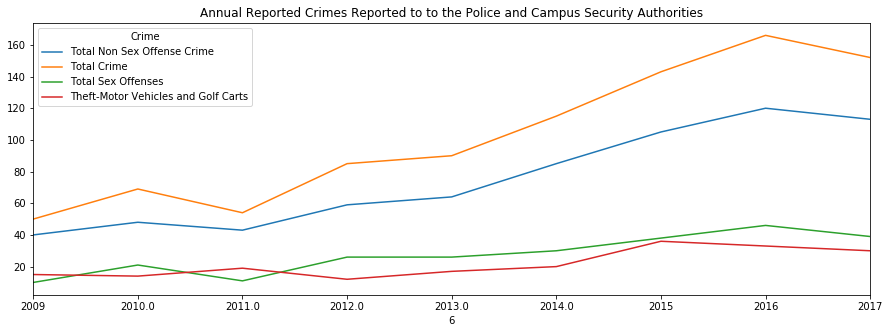

In [261]:
ssfrData["Crime"]["Campus"]['Total Crime'] = ssfrData["Crime"]["Campus"][list(ssfrData["Crime"]["Campus"].columns)[1:]].sum(axis=1)
ssfrData["Crime"]["Campus"]['Total Non Sex Offense Crime'] = ssfrData["Crime"]["Campus"]["Total Crime"] - ssfrData["Crime"]["Campus"]["Total Sex Offenses"]
crimesOfInterest = ["Total Non Sex Offense Crime","Total Crime", "Total Sex Offenses", "Theft-Motor Vehicles and Golf Carts"]
display(ssfrData["Crime"]["Campus"])
ssfrData["Crime"]["Campus"].loc[:, crimesOfInterest].plot(legend=True, title="Annual Reported Crimes Reported to to the Police and Campus Security Authorities")

Arrests,Liquor Law,Drug Violations,Weapon Possession
40,,,
2009,113,45,2
2010.0,31,27,1
2011.0,40,17,2
2012.0,52,6,2
2013.0,89,9,4
2014.0,38,6,2
2015,70,17,4
2016,62,17,5
2017,26,10,9


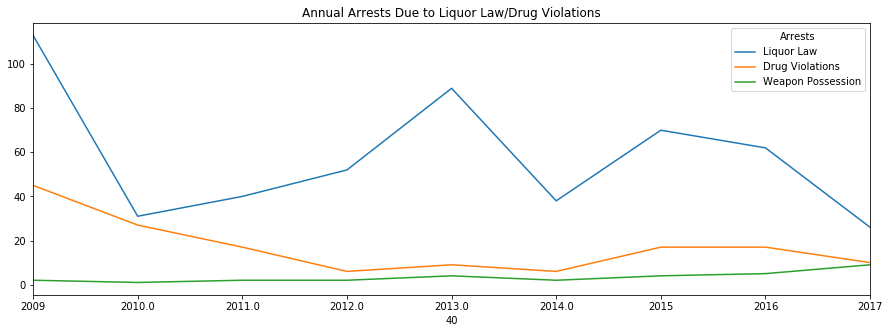

In [262]:
arrestsOfInterest = ['Liquor Law', 'Drug Violations', "Weapon Possession"]
display(ssfrData["Arrest"]["Campus"].loc[:, arrestsOfInterest])
ssfrData["Arrest"]["Campus"].loc[:, arrestsOfInterest].plot(title="Annual Arrests Due to Liquor Law/Drug Violations")

*Exciting!* But for this to be useful, let's control for population - one would expect that crimes go up when population goes up.

In [263]:
demoDf = pd.read_excel('./../Formatted-Data/student_demographics.xlsx', sheet_name="Students Housed on Campus")

types = ["Undergraduate","Graduate"]

demog = {} 
for typ in types:
    demoTwo = deepcopy(demoDf)
    demoTwo = demoTwo[demoTwo['Student Type']==typ]
    demoTwo = demoTwo.T
    demoTwo.columns = demoTwo.iloc[1]
    demoTwo=demoTwo[2:]
    demog[typ] = demoTwo
totalDemog = demog[types[0]]

for col in totalDemog.columns:
    totalDemog.rename(columns={col: types[0] +"s "+col}, inplace=True)
for typ in types:
    for col in demog[typ].columns:
        totalDemog[typ +"s "+col] = demog[typ][col]
totalDemog["Total Housed on Campus"] = totalDemog["Undergraduates Housed on Campus"] + totalDemog["Graduates Housed on Campus"] 

As expected, total population is increasing:

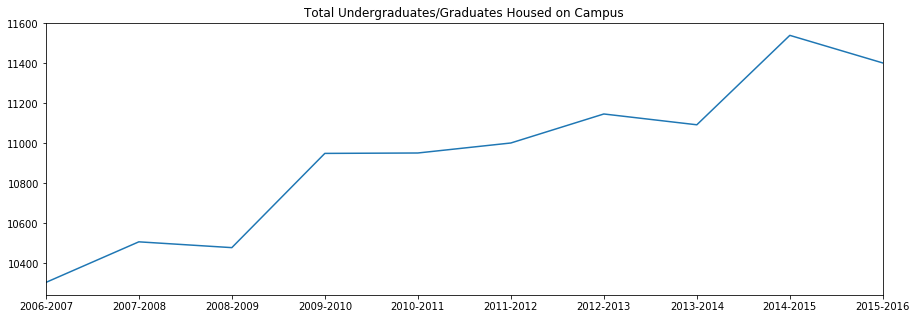

In [264]:
totalDemog["Total Housed on Campus"].plot(title="Total Undergraduates/Graduates Housed on Campus")

Let's go ahead and weight the data, and while we're at it, let's look at the change over time - this is something much easier to work with than the raw data.

In [265]:
def getAnnChange(df, col1):
    d = []
    for index, row in df.iterrows():
        if d==[]:
            d.append(np.nan)
            oldRow = row[col1]
        else:
            d.append(row[col1]-oldRow)
    return d
def getWeightedVal(df, col1):
    d = []
    for index, row in df.iterrows():
        index = str(int(index))
        if d==[]:
            pop = int(totalDemog["Total Housed on Campus"][str(int(index)-1)+"-"+index])
        else:
            if oldIndex==str(2016):
                index = 2016
                pop = int(totalDemog["Total Housed on Campus"]["2015-2016"])
            else:
                pop = int(totalDemog["Total Housed on Campus"][oldIndex+"-"+index])
        d.append(row[col1]/pop)
        oldIndex= index
    return d
def addFuncCol(df, func, col, newName):
    df[newName] = func(df, col)
def dName(var):
    return "Change in "+ var +" Since Previous Year"
def wName(var):
    return "Weighted "+ var +" By Campus Population"
for arrest in arrestsOfInterest:
    addFuncCol(ssfrData["Arrest"]["Campus"], getWeightedVal, arrest, wName(arrest))
    addFuncCol(ssfrData["Arrest"]["Campus"], getAnnChange, wName(arrest), dName(wName(arrest)))
for crime in crimesOfInterest:
    addFuncCol(ssfrData["Crime"]["Campus"], getWeightedVal, crime, wName(crime))
    addFuncCol(ssfrData["Crime"]["Campus"], getAnnChange, wName(crime), dName(wName(crime)))

## Data Weighted by Population, Changes Over Time

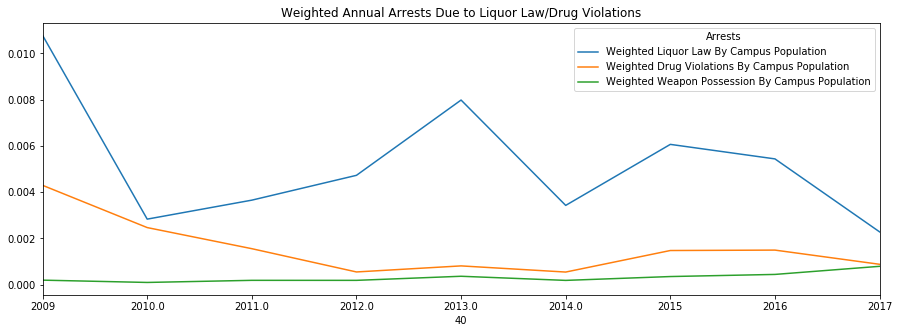

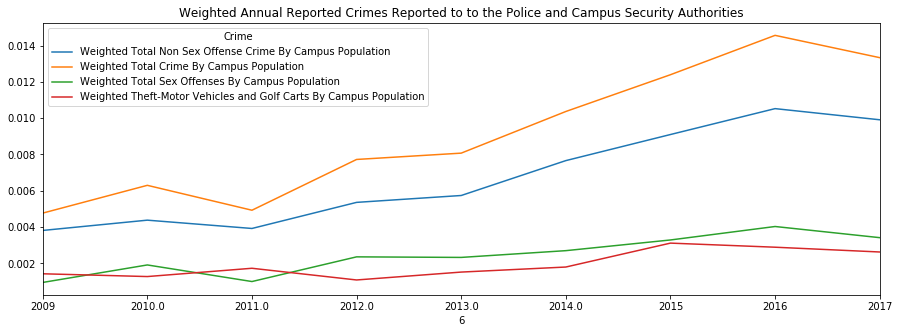

In [266]:
wArrestsOfInterest = list(map(wName, arrestsOfInterest))
wCrimesOfInterest = list(map(wName, crimesOfInterest))
ssfrData["Arrest"]["Campus"].loc[:, wArrestsOfInterest].plot(title="Weighted Annual Arrests Due to Liquor Law/Drug Violations")
ssfrData["Crime"]["Campus"].loc[:, wCrimesOfInterest].plot(title="Weighted Annual Reported Crimes Reported to to the Police and Campus Security Authorities")

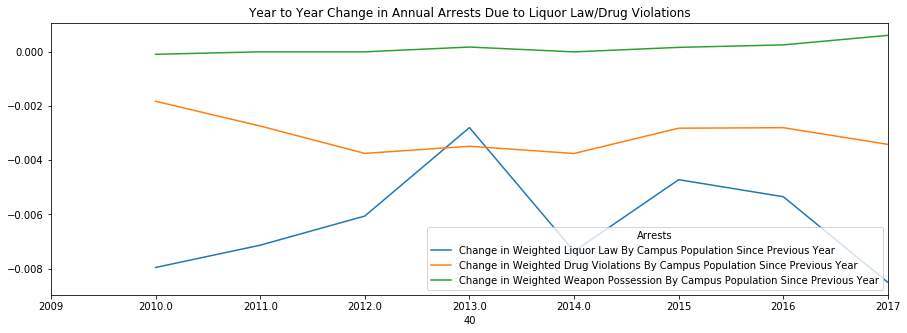

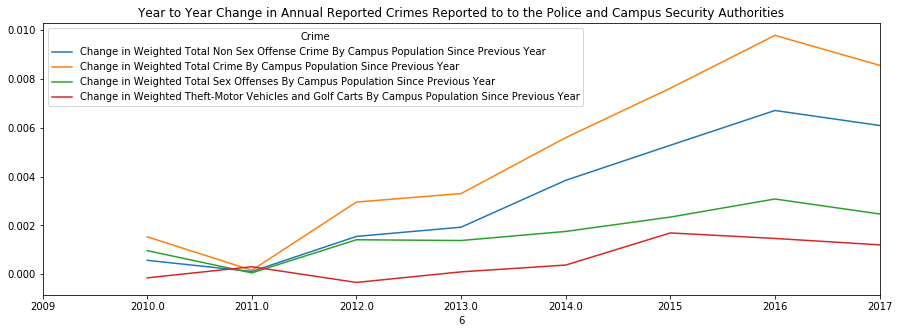

In [267]:
dwArrestsOfInterest = list(map(dName, map(wName, arrestsOfInterest)))
dwCrimesOfInterest = list(map(dName, map(wName, crimesOfInterest)))
ssfrData["Arrest"]["Campus"].loc[:, dwArrestsOfInterest].plot(title="Year to Year Change in Annual Arrests Due to Liquor Law/Drug Violations")
ssfrData["Crime"]["Campus"].loc[:, dwCrimesOfInterest].plot(title="Year to Year Change in Annual Reported Crimes Reported to to the Police and Campus Security Authorities")

## Show Me Those p-Values Baby 

In [268]:
dwTotalCrime = ssfrData["Crime"]["Campus"].loc[:, dName(wName("Total Crime"))][1:]
ttest1Samp(dwTotalCrime,0)

Ttest_1sampResult(statistic=4.000998331255234, pvalue=0.00518332259690012)

In [269]:
dwTotalNSOCrime = ssfrData["Crime"]["Campus"].loc[:, dName(wName("Total Non Sex Offense Crime"))][1:]
ttest1Samp(dwTotalNSOCrime,0)

Ttest_1sampResult(statistic=3.5862644768982954, pvalue=0.008901398535269223)

In [270]:
dwWeap = ssfrData["Arrest"]["Campus"].loc[:, dName(wName("Weapon Possession"))][1:]
ttest1Samp(dwWeap,0)

Ttest_1sampResult(statistic=1.6570325941273838, pvalue=0.1414810274368557)

In [271]:
dwDrug = ssfrData["Arrest"]["Campus"].loc[:, dName(wName("Drug Violations"))][1:]
ttest1Samp(dwDrug,0)

Ttest_1sampResult(statistic=-13.277602401895244, pvalue=3.215924943939564e-06)

In [272]:
dwLiq = ssfrData["Arrest"]["Campus"].loc[:, dName(wName("Liquor Law"))][1:]
ttest1Samp(dwLiq,0)

Ttest_1sampResult(statistic=-9.312558895620738, pvalue=3.4145112995274805e-05)

## But what does this *mean*?

Well, we can be pretty certain that general crime is increasing and that general drug/liquor arrests are decreasing (but likely not arrests generally (see Weapon Posession)). Why? That's a good question. There's a few possibilities:

1. Alcohol/Drug use has gone down and by proxy there are fewer arrests
2. Alcohol/Drug use has stayed the same/gotten more prevalent and
    - Police aren't enforcing policy as stringently as before (non-specifically)
    - Police aren't enforcing drug specific policies as stringently as before
    - People are hiding their activity better (eg. just not getting caught)
    - People are being reprimanded in a way not captured by these numbers

Well, let's go through it.

## Is a Decrease in Alcohol/Drug Use The Reason For Less Arrests?